In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

In [26]:
# Create a toy dataset with 2 features and 3 classes (0, 1, 2) with a bit of noise
n_samples = 150000
n_features = 2
n_classes = 3

X = np.random.randn(n_samples, n_features)
y = np.zeros(n_samples)
for i in range(n_classes):
    X[y == i] += np.random.randn(1, n_features) * 1.2

y = np.where(X[:, 0] > 0, 0, 1)
y = np.where(X[:, 1] > 0, y, y + 1)



In [27]:
print(X)

[[ 0.92442015 -1.77065658]
 [-1.5645789  -0.64893186]
 [ 2.06289951 -0.50917567]
 ...
 [-0.19791944 -0.15610916]
 [ 0.43566915 -1.55672836]
 [ 0.35279788 -1.57212245]]


In [28]:
print(y)

[1 2 1 ... 2 1 1]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Train a Gaussian Naive Bayes classifier
clf = naive_bayes.GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [30]:
# Predict class labels and probabilities
y_pred_proba = clf.predict_proba(X_test)

In [31]:
# Calculate Softmax score
softmax_score = np.max(y_pred_proba, axis=1)

In [32]:
# Initialize the Conformal Prediction classifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal)

MapieClassifier(cv='prefit', estimator=GaussianNB())

In [33]:
alpha = [0.2, 0.1, 0.05]  #Add aplha values (1-required_prediction_accuracy)
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

In [34]:
print(mapie_score.quantiles_)

[0.42919332 0.52912564 0.64541502]


In [45]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#d62728", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

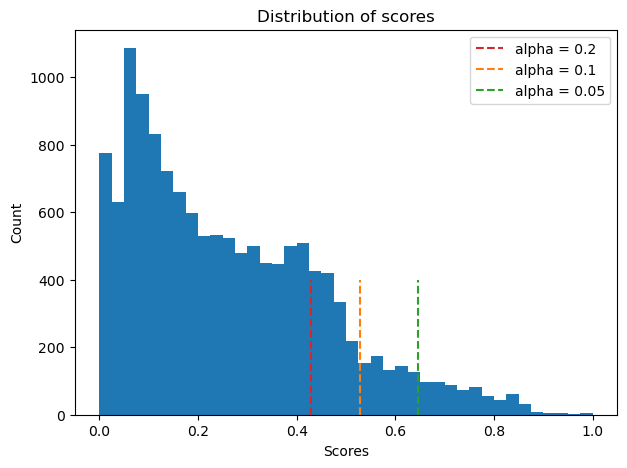

In [46]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)

In [37]:
def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.Purples
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
    axs = {0: ax1, 1: ax2, 2:  ax3, 3: ax4}
    axs[0].scatter(
        X[:, 0],
        X[:, 1],
        color=y_pred_col,
        marker='.',
        s=10,
        alpha=0.4
    )
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i+1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3
        )
        plt.colorbar(num_labels, ax=axs[i+1])
        axs[i+1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()


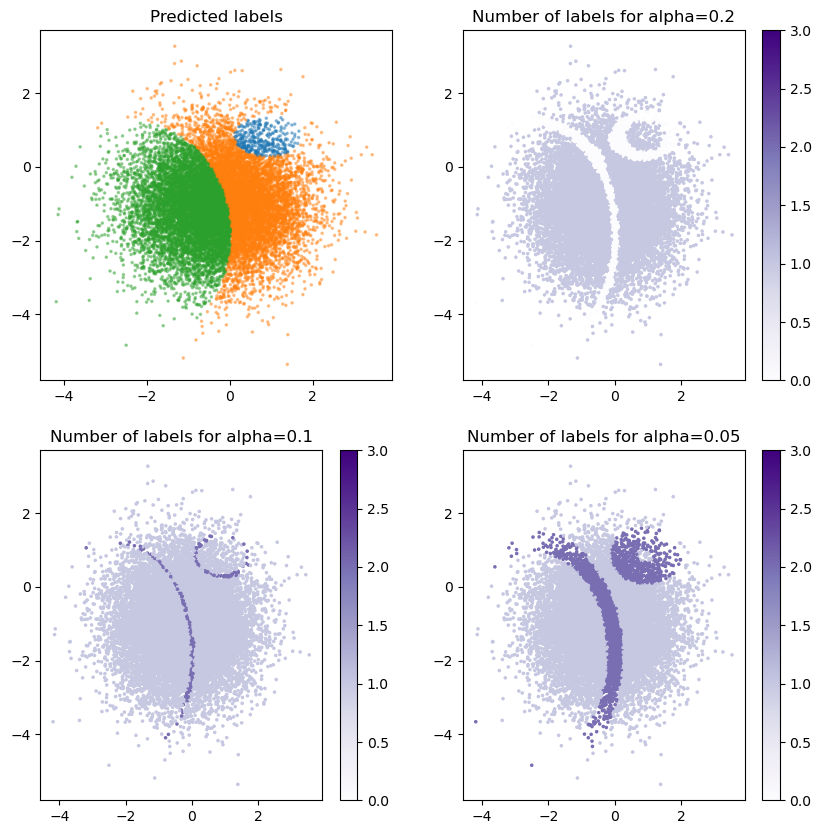

In [38]:
plot_results(alpha, X_test, y_pred_score, y_ps_score)